In [2]:
# Initialize Otter
import otter
grader = otter.Notebook("HW_2_system_analysis.ipynb")

# HW 2: Analysis of a mass-damped system

Resources: Lecture slides describing the homework: https://docs.google.com/presentation/d/1MwF34w30rjzLS5-IYj0ZWT5CjsLeFc7qlG_Eq9rFdZ8/edit?usp=sharing All of the equations for this homework are in those slides.

- Part 1/week 4 does not build on anything specific in lab 4, but uses functions and numpy
- Part 2/week 5: Do lab 5 before homework 

In the first part of this homework the focus is on doing an analysis "from scratch", in the sense that we will not be
providing a lot of shell code. The second half is on how to translate a general equation of the form

  *derivative of state at time t = f( state at time t )*
  
into code (also known as simulation).

Programming practice: The focus in this assignment is on deciding when to create a function and what parameters to pass in and out of the function.

Following on from lab 5, the second part of the assignment will be an example of writing an iterative function - one where the intention is to call the function multiple times, each time passing in the values returned from the previous function call. This can be a bit difficult to wrap your head around, so if you get stuck go back to the simpler examples and/or do it on paper yourself a few iterations.

We've provided results (as a json file) for three of the included data sets. We will, however, be testing on different data sets, so make sure your code works for any data file of the correct format.

TODOS: For each helper function
- Write the function
- Check that it works

You have some flexibility as to how the write the helper functions, but you must use the names/input/output format given or the autograder won't work...

Helper function is not a technical term - it's just what I call a function that does some part of the functionality of the entire task.

## Helper function 1 - load the data and check that it's valid
 - Input: File name (with path)
 - Output: Two numpy arrays
   -- 1st numpy array: The time values
   -- 2nd numpy array: The function values that correspond to the time values
   
You MUST use this format and the file name given, or the autograder will fail.

The two arrays should be of the same length

Some expectations on the data files
 - Always has at least three rows
 --First row is a header row
- The first column is the time values (will be monotonically increasing)
- The second column is the values that correspond to the time values (final value of this will be greater than initial)

A good habit is to check that these are true, and throw an error if it's not

In [3]:
# TODO: Put your imports here
import numpy as np
import json as json
from scipy.stats import linregress
import matplotlib.pyplot as plt
from numpy.polynomial import polynomial
import math
import csv as csv

In [4]:
# TODO: Put your function definition for loading the data here

# You must name your function this with the filename passed in
#  It should return ts, vs
def load_data_from_file(fname):
    data = np.loadtxt(f"{fname}", dtype= float, delimiter= ',', skiprows=1)
    t_values = data[:,0]
    y_values = data[:,1]
    return t_values, y_values


In [5]:
# TODO: Call your function here

# Make sure you assign the t and y values to the variable names ts, vs
ts, vs = load_data_from_file("Data/data1.csv")
print(ts)
print(len(ts))
print(vs) 
print(len(vs))

[0.0000e+00 1.0000e-03 2.0000e-03 ... 1.9997e+01 1.9998e+01 1.9999e+01]
20000
[-1.00000000e+00 -9.99950017e-01 -9.99800140e-01 ... -8.08518116e-06
 -8.52676808e-06 -8.96706076e-06]
20000


In [6]:
grader.check("load_data")

load_data results: All test cases passed!

## Helper function 2 - get the index of the local minima or local maxima

Look at the equations in the slides - why is this a useful helper function?

- Input (2): A numpy array, boolean (True: find local maxima, False: find local minima)
- Output: The index of every local maxima or local minima in the input array

Use the **argrelmin** and **argrelmax** functions to find the indices of the minimum and maximum values in a numpy array.
These functions are in scipy.signal module. They essentially bundle the find max, and where code we've been writing
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.argrelmin.html
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.argrelmax.html

In [7]:


# TODO: Add importing argrelmin and argrelmax to your imports. They are in scipy.signal
from scipy.signal import argrelmin, argrelmax, argrelextrema

# TODO: Write this function.
# This function takes in data and whether or not to search for the peak or the valley. It returns an index or None if no peak/valley
# If b_peak_or_valley is True, return the peak
def find_peak_or_valley(data, b_peak_or_valley):
    
    if b_peak_or_valley == True:
        peak_index = argrelmax(data)
        return (peak_index[0])
    else:
        peak_index = argrelmin(data)
        if peak_index[0].size < 0:
            return None
        else:
            return (peak_index[0])
    pass

In [8]:
# Test your function with datas.
list = []

data_a = np.array([1.0, 3.0, 4.0, 7.0, 6.0, 8.0, 9.0, 10.0, 5.0])
data_b = np.array([-2.5, 1.0, 4.0, 8.0, 4.0, 1.0, -2.5])
data_c = np.array([1.1, 2.2, 3.3, 4.4])

something = find_peak_or_valley(data_a, b_peak_or_valley=True)
print(something)
# TODO Add tests - what should the correct values be? If you are unsure, try plotting the data

[3 7]


In [9]:
grader.check("get_index")

get_index results: All test cases passed!

## Analysis code

TODO: Write a function that takes in a file name and outputs a dictionary with the values listed below
 - You must use the names given (see json file/example in homework slide)
 - See homework slides for further definitions/equations

Check the corresponding json file and plot for the correct values 

### System values (Slide 8)
 - c_initial - the initial position of the system (the first value)
 - c_peak - the largest position of the system (or the first peak position, see Figure 4.14)
 - c_final - the final, steady-state position of the system (the last value, see Figure 4.14)

Note: For this assignment we'll just use the last value, but you could also average the last few values

###  Estimate peak and valley times and values
 - c_second_peak - the second peak position of the system (local maximum value)
 - c_valley - the first valley position of the system (local minimum value)
 - t_peak - the peak time of the system
 - t_second_peak - the second peak time of the system
 - t_valley - the first valley time of the system
 - peak_period - the period between two peaks, (t_second_peak - t_peak) or (t_valley - t_peak)*2
 - perc_overshoot - percentage over shoot (% OS). This is the amount that the system overshoots c_final, expressed as a percentage of the range c_initial to c_final.

###    Estimate model values
 - system_mass - assume the mass is 1 (this will not be true in part II)
 - system_spring - this is omega_n^2 * system_mass (see slides)
 - system_damping - the damping coeifficient (the linear coefficient, see slides)

You may write some additional helper functions here, if you wish. Actually, I recommend writing this in pieces/multiple functions. One breakdown is the one given above - calculate the values in turn.

I'd suggest writing a test function for each of the group of equations above, where you test against the answers in the data1.json file (with the data1.csv file as input). 

I have written a general-purpose test function for you, but it tests everything all at once.

In [10]:
import math
nums = load_data_from_file("Data/data1.csv")
i_vant = np.array(nums)
print(i_vant[0:1,0])
print(nums[0])

[0.]
[0.0000e+00 1.0000e-03 2.0000e-03 ... 1.9997e+01 1.9998e+01 1.9999e+01]


In [11]:
# TODO: Open the filename and call the analyze_data_from_values function. Return the dictionary.
# If no mass is given, assume it is 1
def analyze_data(fname, m=1.0):
    ts, vs = load_data_from_file(fname)
    data = ts, vs
    c_initial = data[1][0] 
    c_final = data[1][-1]     
    peaks = find_peak_or_valley(vs, b_peak_or_valley=True) 
    c_peak = vs[peaks[0]]
    c_second_peak = vs[peaks[1]]    
    t_peak = ts[peaks[0]]
    t_second_peak = ts[peaks[1]]
    valleys = find_peak_or_valley(vs, b_peak_or_valley=False)
    c_valley = vs[valleys[0]]
    t_valley = ts[valleys[0]]
    peak_period = t_second_peak - t_peak
    perc_overshoot = (c_final - c_valley) / (c_peak-c_final) * 100 
    
    mass = m
    zeta = (-(math.log(perc_overshoot/100))) / (math.sqrt(math.pi**2 + (math.log(perc_overshoot/100))**2))
    omega_n = (2*math.pi) / (peak_period*math.sqrt(1 - zeta**2))
    system_spring = mass * omega_n**2
    system_damping = 2 * mass * zeta * omega_n
    my_dict = {"c_initial": c_initial, 
            "c_final": c_final, 
            "c_peak": c_peak, 
            "c_second_peak": c_second_peak, 
            "t_peak": t_peak, 
            "t_second_peak": t_second_peak, 
            "c_valley": c_valley, 
            "t_valley": t_valley, 
            "peak_period": peak_period, 
            "perc_overshoot": perc_overshoot,
            "system_mass": mass,
            "system_spring": system_spring,
            "system_damping": system_damping,
            }
    return my_dict
    pass

In [40]:
# Another cell for another function

In [41]:
# Another cell for testing the above function...

In [12]:
# Another cell for another function... 
nums = analyze_data("Data/data1.csv", m=1)
print(nums)
nums_two = analyze_data("Data/data2.csv", m=1)
print(nums_two)

{'c_initial': -1.0, 'c_final': -8.96706075522e-06, 'c_peak': 0.854459357957, 'c_second_peak': 0.623856525102, 't_peak': 0.315, 't_second_peak': 0.944, 'c_valley': -0.730114989685, 't_valley': 0.629, 'peak_period': 0.629, 'perc_overshoot': 85.44565096770248, 'system_mass': 1, 'system_spring': 100.03356014604226, 'system_damping': 1.000252294817643}
{'c_initial': -1.0, 'c_final': -5.01781721371e-11, 'c_peak': 0.163033062405, 'c_second_peak': 0.00433340730371, 't_peak': 0.726, 't_second_peak': 2.177, 'c_valley': -0.02657993445, 't_valley': 1.451, 'peak_period': 1.451, 'perc_overshoot': 16.303401285324753, 'system_mass': 1, 'system_spring': 25.001340644000145, 'system_damping': 5.000128000364272}


In [14]:
# TEST CELL

# Call the analyze_data function(s) with one of the data files 
check_dict = analyze_data("Data/data1.csv", )    
print(check_dict)
check_dict_2 = analyze_data("Data/data2.csv", )  
print(check_dict_2)

{'c_initial': -1.0, 'c_final': -8.96706075522e-06, 'c_peak': 0.854459357957, 'c_second_peak': 0.623856525102, 't_peak': 0.315, 't_second_peak': 0.944, 'c_valley': -0.730114989685, 't_valley': 0.629, 'peak_period': 0.629, 'perc_overshoot': 85.44565096770248, 'system_mass': 1.0, 'system_spring': 100.03356014604226, 'system_damping': 1.000252294817643}
{'c_initial': -1.0, 'c_final': -5.01781721371e-11, 'c_peak': 0.163033062405, 'c_second_peak': 0.00433340730371, 't_peak': 0.726, 't_second_peak': 2.177, 'c_valley': -0.02657993445, 't_valley': 1.451, 'peak_period': 1.451, 'perc_overshoot': 16.303401285324753, 'system_mass': 1.0, 'system_spring': 25.001340644000145, 'system_damping': 5.000128000364272}


In [15]:
def compare_dictionaries(fname_dictionary, check_dict):
    """ Open up the json file in fname and compare to check_dict
    @param fname_dictionary one of dataX.json
    @param check_dict - your dictionary with parameters
    @returns True or False if the same (within epsilon)"""
    from json import load
    with open(fname_dictionary, 'r') as fp:
        answ_dict = load(fp)

    b_ret = True
    for k, v in answ_dict.items():
        try:
            if not np.isclose(v, check_dict[k], atol=0.1):
                print(f"Key {k} is not close, correct value {v}, incorrect {check_dict[k]}")
                b_ret = False
        except KeyError:
            print(f"Key {k} not found in your dictionary")
            b_ret = False
    return b_ret


In [16]:
grader.check("analysis")

analysis results: All test cases passed!

<!-- BEGIN QUESTION -->

## Plot the data and the system parameters

TODO Plot the data with the parameters, similar to the figures in the slides

You should have **the first and second peaks**, **the first valley**, and **peak period** plotted on the figure

Optional: Plot all of the data on the left hand side, then plot a "clipped" version of the data (clip to where it stops vibrating) with the parameters on them.

Create one plot each for each data file.

- matplotlib has a text function for placing text

When deciding what functions to write: I've left four blocks here. The first block should be function(s) that do the plotting/reading/analysis, etc. Blocks 2-4 should just call those functions with the different data files.

In [17]:
# An example of creating a "helper" function that does a plotting task 
def draw_corner(axs, x_values, y_values, ls, col):
    axs.plot([x_values[0], x_values[1]], [y_values[1], y_values[1]], linestyle=ls, color=col)
    axs.plot([x_values[1], x_values[1]], [y_values[0], y_values[1]], linestyle=ls, color=col)


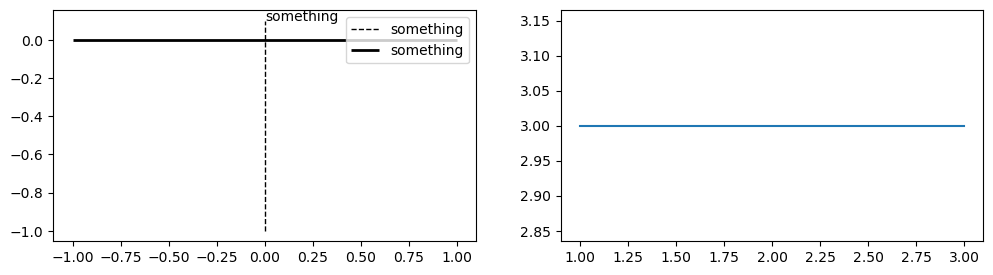

In [18]:
nrows = 1
ncols = 2
fig, axs = plt.subplots(nrows, ncols, figsize=(12, 3))
axs[0].vlines(0, -1, 0.1, color='k',linestyle = 'dashed', lw=1, label='something')
axs[0].hlines(0, -1, 1, color='k', lw=2, label='something')
axs[1].plot ([1, 3], [3, 3], label='something')
axs[0].annotate('something', xy=(0, 0), xytext=(-0, 0.1))
axs[0].legend()

In [19]:

def draw_corner(ax, peak_x, y_values, col, lab):
    ax.hlines(peak_x,0, y_values[0], linestyle= 'dashed', color=col)
    ax.vlines(y_values[0], -1, peak_x, linestyle= 'dashed', color=col)
    print(peak_x)
    x = float(peak_x)
    y = float(y_values[0])
    ax.text(y,x ,lab)
    return ax.plot

def draw_period(ax, t_peak, t_second_peak, col, lab):
    ax.plot([t_peak, t_second_peak], [0, 0], label=lab, linestyle= 'dashed', color=col)
    x = float(t_second_peak[0])
    y = float(0)
    ax.text(x,y, lab)
    



In [20]:
# Cell for additional plot functions
def plot_data(ax, vs, ts, peaks, valleys):
    ax.plot(ts, vs, linestyle='-', color='k')
    draw_corner(ax, peaks[0][0], peaks[1], 'r', 'First Peak')
    draw_corner(ax, peaks[0][1], peaks[0], 'b', 'Second Peak')
    draw_corner(ax, valleys[0][0], [0,valleys[1][0]], 'g', 'First Valley')
    draw_period(ax, peaks[0], peaks[1], 'r', 'Period')
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Value c(t)")
    
    return axs


In [50]:
# test for plot_data

0.854459357957
0.623856525102
-0.730114989685


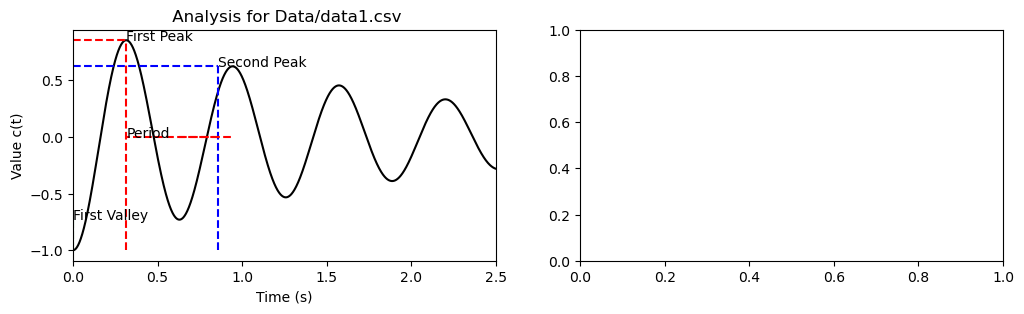

In [21]:
nrows = 1
ncols = 2
fig, axs = plt.subplots(nrows, ncols, figsize=(12, 3))
# TODO: 
#  Write a function that reads in the data, analyzes it, then plots it
def plot_system(ax, fname, m=1.0):
    data = analyze_data(fname, m)  
    ts, vs = load_data_from_file(fname)
    steady = data['c_final']
    peaks = [data['c_peak'], data['c_second_peak']],[data['t_peak'], data['t_second_peak']]
    valleys = [data['c_valley']], [data['t_valley']]
    plot_data(ax, vs, ts, peaks, valleys)
    times = peaks[1]
    ax.set_xlim(0, 2.5)
    
    ax.set_title(f" Analysis for {fname}")
    
    
    pass
nums = plot_system(axs[0], "Data/data1.csv", m=1)

0.854459357957
0.623856525102
-0.730114989685


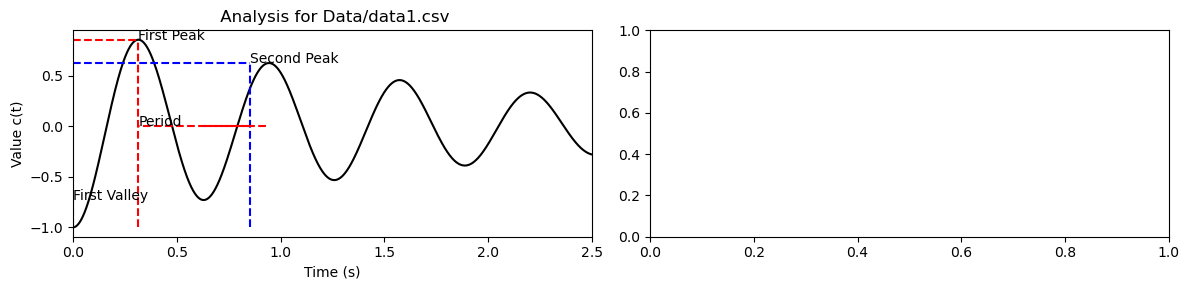

In [22]:
nrows = 1
ncols = 2
fig, axs = plt.subplots(nrows, ncols, figsize=(12, 3))

# Read, analyze, and plot data 1
plot_system(axs[0], "Data/data1.csv", m=1)

# Make it fit better
fig.tight_layout()

0.163033062405
0.00433340730371
-0.02657993445


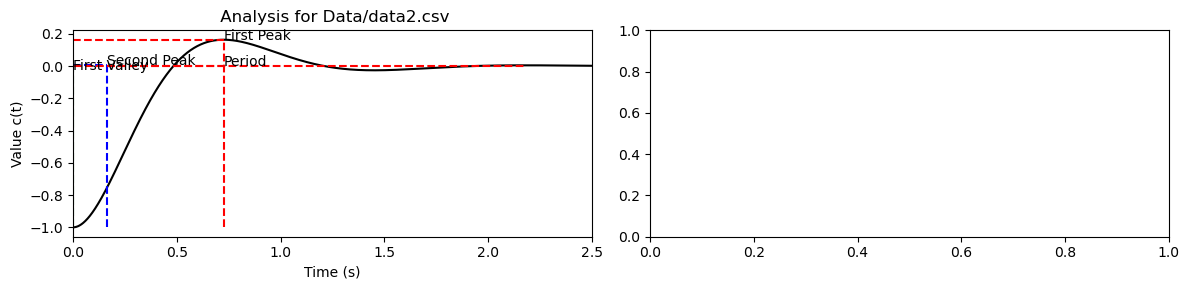

In [23]:
nrows = 1
ncols = 2
fig, axs = plt.subplots(nrows, ncols, figsize=(12, 3))

# Read, analyze, and plot data 2
plot_system(axs[0], "Data/data2.csv", m=1)

# Make it fit better
fig.tight_layout()

0.0283741157133
2.28479550492e-05
-0.000805165924902


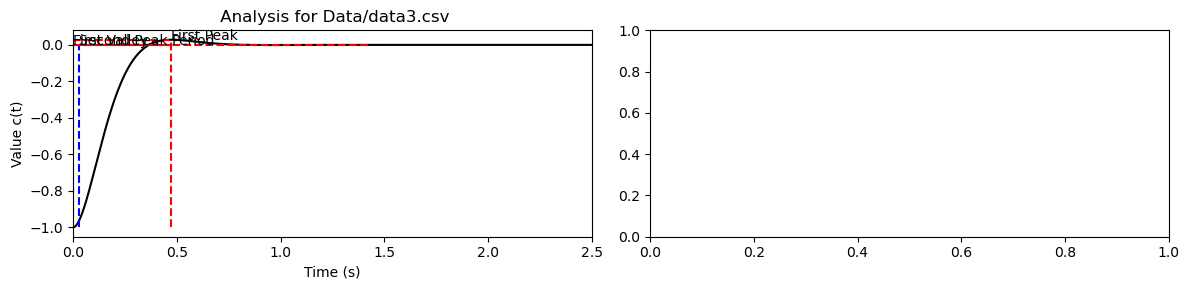

In [24]:
nrows = 1
ncols = 2
fig, axs = plt.subplots(nrows, ncols, figsize=(12, 3))

# Read, analyze, and plot data 3
plot_system(axs[0], "Data/data3.csv", m=1)
# Make it fit better
fig.tight_layout()

In [25]:
# Manual grade
print("This is a manually-graded question; there is no grader.check() function. See rubric and slides for more information on expected output.")

This is a manually-graded question; there is no grader.check() function. See rubric and slides for more information on expected output.


<!-- END QUESTION -->

# Part 2 - ode simulation

In this part of the assignment you'll simulate the spring-mass system yourself. We'll follow the second half of Lab 5 - using ode to do the simulation (you just have to write the derivative function and the set-up code).

This should be nearly identical to the predator_prey_derivative ode example (from a coding syntax standpoint). The equations and the meanings of the variables will be different, however.

- Like the c_tutorial_iterative_systems example, you will need to calculate two values, but this time dx/dt and dx^2/dt^2 
- Like the predator_prey_derivative example, you will
-- create a derivative function that takes in a 2 dimensional current state (x, dx/dt), t (not used), and params (c, k, and m) and returns dx/dt and dx^2/d^2t
-- params will be a dictionary that you create in the calling code
-- create a set of time values to evaluate the system at
-- use ode to do the actual forward simulation

Functions you'll need

- a derivative function (like predator_prey_derivative)
- a function/cell to create the initial data to simulate and write out/save the results
- a function that calls your code from part 1 to analyze and plot the data (do NOT write new plotting/analysis code). Two options:
-- Write the data out to a file then read it back in using the code you just wrote in the previous part
-- If you split up your plot/analysis functions the right way, you can just pass the data directly to the plot/analysis functions

Parameters:

- c: damping term (system_damping in json file)
- k: spring term (system_spring in json file)
- m: mass (don't forget to put this value in the analysis dictionary)

Equation:

-  dx/dt = dx/dt
-  d^2x/d^2t = (-c * dx/dt - k * x) / m


In [26]:
# TODO: You'll need to import integrate
from scipy.integrate import odeint

In [27]:
def deriv_func(state, t, params):
    x, dx_dt = state
    dx_dt = dx_dt
    dx_two_dt = ((-params['system_damping']*dx_dt) - (params['system_spring']*x)) / params['system_mass']

    return np.array(dx_dt)
    pass

def solve_system(params, t):
    state_initial = [params['c_initial'], 0]
    state = odeint(deriv_func, state_initial, t, args=(params,))
    datas = np.hstack((t[:, np.newaxis], state))
    return datas
    pass




In [58]:
# TODO: write a deriative function.
#  Note that the input state will have x and the derivative of x in it
#   You will return the derivative of x and the derivative of the derivative of x
#   Note that the derivative never changes - you only have to calculate the second derivative

    

NameError: name 'integrate' is not defined

In [28]:
#- c: damping term (system_damping in json file)
#- k: spring term (system_spring in json file)
#   m: mass (don't forget to put this value in the analysis dictionary)# TEST CELL
# Write one call to the derivative function to test it with known values

test_dat = analyze_data("Data/data1.csv", m=1) 
print(test_dat)
t = np.linspace(0, 20, 20000)
sol = []
sol = solve_system(test_dat, t)

print(sol)


{'c_initial': -1.0, 'c_final': -8.96706075522e-06, 'c_peak': 0.854459357957, 'c_second_peak': 0.623856525102, 't_peak': 0.315, 't_second_peak': 0.944, 'c_valley': -0.730114989685, 't_valley': 0.629, 'peak_period': 0.629, 'perc_overshoot': 85.44565096770248, 'system_mass': 1, 'system_spring': 100.03356014604226, 'system_damping': 1.000252294817643}
[[ 0.00000000e+00 -1.00000000e+00  0.00000000e+00]
 [ 1.00005000e-03 -9.99949995e-01  9.99868630e-02]
 [ 2.00010001e-03 -9.99800053e-01  1.99863775e-01]
 ...
 [ 1.99979999e+01 -9.98421573e-06 -4.36200248e-04]
 [ 1.99989999e+01 -1.04197173e-05 -4.34743585e-04]
 [ 2.00000000e+01 -1.08537409e-05 -4.33244912e-04]]


In [ ]:
# TODO write a function that takes in the starting conditions (x and the derivative of x), along with the parameters
#  you need to calculate the derivative (zeta, k, and m)
# Call integrate and return the result of that function, along with the t values
#   You might also want the step for the t and the total amount of time to integrate over as parameters


In [29]:
# Run the ode with the following parameters and store the answer in dict_answ
# Make sure you run the simulation long enough for it to stabilize
# x0 = -0.5, c = 1.1, m = 2.0, k = 50.0
testrams = {"c_initial": -0.5, "system_mass": 2.0, "system_spring": 50.0, "system_damping": 1.1}
test_dat = solve_system(testrams, t)

with open('test_dat3.csv', 'w', newline = '') as csvfile:
    fieldnames = ['time', 'value']  
    writer = csv.DictWriter(csvfile, fieldnames = fieldnames)
    for value in test_dat:
        writer.writerow({'time': value[0], 'value': value[1]}) 
    csvfile.close()


dict_answ = analyze_data("test_dat3.csv", m=2.0)
print(dict_answ)

{'c_initial': -0.4999937507532876, 'c_final': -0.0015148941650791495, 'c_peak': 0.42054767707276036, 'c_second_peak': 0.2975131841354345, 't_peak': 0.6290314515725787, 't_second_peak': 1.8880944047202362, 'c_valley': -0.3537201905296715, 't_valley': 1.2580629031451573, 'peak_period': 1.2590629531476574, 'perc_overshoot': 83.44859752231349, 'system_mass': 2.0, 'system_spring': 49.97273066582906, 'system_damping': 1.1496762208604603}


In [30]:
grader.check("ode_functions")

ode_functions results:
    ode_functions - 1 result:
        ❌ Test case failed
        Trying:
            assert(compare_dictionaries('Data/sim_and_plot_answer_a.json', dict_answ))
        Expecting nothing
        **********************************************************************
        Line 1, in ode_functions 0
        Failed example:
            assert(compare_dictionaries('Data/sim_and_plot_answer_a.json', dict_answ))
        Exception raised:
            Traceback (most recent call last):
              File "c:\Users\yeasshhhh\anaconda3\Lib\doctest.py", line 1351, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest ode_functions 0[0]>", line 1, in <module>
                assert(compare_dictionaries('Data/sim_and_plot_answer_a.json', dict_answ))
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
              File "C:\Users\yeasshhhh\AppData\Local\Temp\ipykernel_14332\3566888414.py", line 8, in compare_dictionaries
                answ_dict = load(fp)
                            ^^^^^^^^
              File "c:\Users\yeasshhhh\anaconda3\Lib\json\__init__.py", line 293, in load
                return loads(fp.read(),
                       ^^^^^^^^^^^^^^^^
              File "c:\Users\yeasshhhh\anaconda3\Lib\json\__init__.py", line 346, in loads
                return _default_decoder.decode(s)
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^
              File "c:\Users\yeasshhhh\anaconda3\Lib\json\decoder.py", line 337, in decode
                obj, end = self.raw_decode(s, idx=_w(s, 0).end())
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
              File "c:\Users\yeasshhhh\anaconda3\Lib\json\decoder.py", line 355, in raw_decode
                raise JSONDecodeError("Expecting value", s, err.value) from None
            json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)

<!-- BEGIN QUESTION -->

# Part b: Recreate data 1
Using your simulation code, re-create the plot for data 1

- Get the parameters from your initial analysis
- Pick a reasonable stop time
- Plot the result

0.8544587455071185
0.623855449060062
-0.730115195651133
{'c_initial': -0.9999500122381991, 'c_final': -9.403485599167385e-06, 'c_peak': 0.8544587455071185, 'c_second_peak': 0.623855449060062, 't_peak': 0.3150157507875394, 't_second_peak': 0.9440472023601181, 'c_valley': -0.730115195651133, 't_valley': 0.6290314515725787, 'peak_period': 0.6290314515725787, 'perc_overshoot': 85.445641598954, 'system_mass': 1.0, 'system_spring': 100.02355738879976, 'system_damping': 1.0002029794380491}


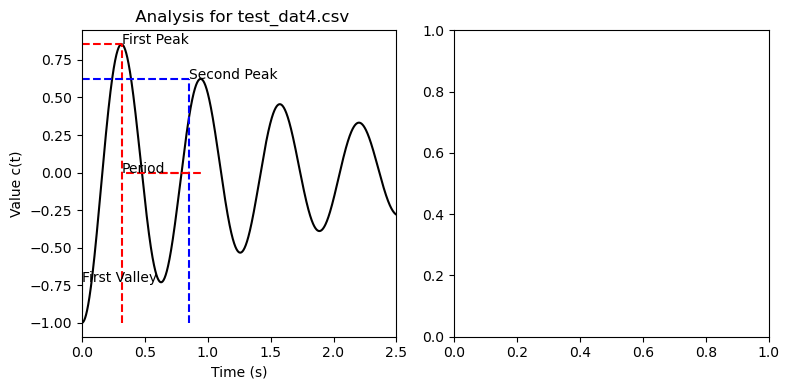

In [31]:
nrows = 1
ncols = 2
fig, axs = plt.subplots(nrows, ncols, figsize=(8, 4))


# Run your simulation, analyze it, and plot the results
# This SHOULD just be calling existing functions
# x0 = -1.0, c = 1.0, m = 1.0, k = 100.0
testrams = {"c_initial": -1.0, "system_mass": 1.0, "system_spring": 100.0, "system_damping": 1.0}
test_dat = solve_system(testrams, t)

with open('test_dat4.csv', 'w', newline = '') as csvfile:
    fieldnames = ['time', 'value']  
    writer = csv.DictWriter(csvfile, fieldnames = fieldnames)
    for value in test_dat:
        writer.writerow({'time': value[0], 'value': value[1]}) 
    csvfile.close() 
dict_answ = analyze_data("test_dat4.csv", m=1.0)
plot_system(axs[0], "test_dat4.csv", m=1.0)
print(dict_answ)

# Make it fit better
fig.tight_layout()


In [32]:
# Manual grade
print("This is a manually-graded question; there is no grader.check() function. See rubric and slides for more information on expected output.")

This is a manually-graded question; there is no grader.check() function. See rubric and slides for more information on expected output.


<!-- END QUESTION -->

# Part c - increasing mass

Increase the mass from 1 to 10 (but use the same c and k parameters from the previous problem).

Plot the system. Has it stabilized? Adjust the time to run so that it stabilizes. Then plot the result.

Set dict_bigger_analysis to be the analysis with mass 

{'c_initial': -0.9999949997329792, 'c_final': -0.34030034761477124, 'c_peak': 0.9515335632269802, 'c_second_peak': 0.8615361035933183, 't_peak': 0.9940497024851243, 't_second_peak': 2.981149057452873, 'c_valley': -0.9054181310944676, 't_valley': 1.9870993549677485, 'peak_period': 1.9870993549677487, 'perc_overshoot': 43.74539007970993, 'system_mass': 10.0, 'system_spring': 106.90647545330384, 'system_damping': 16.643031890195225}
0.9515335632269802
0.8615361035933183
-0.9054181310944676


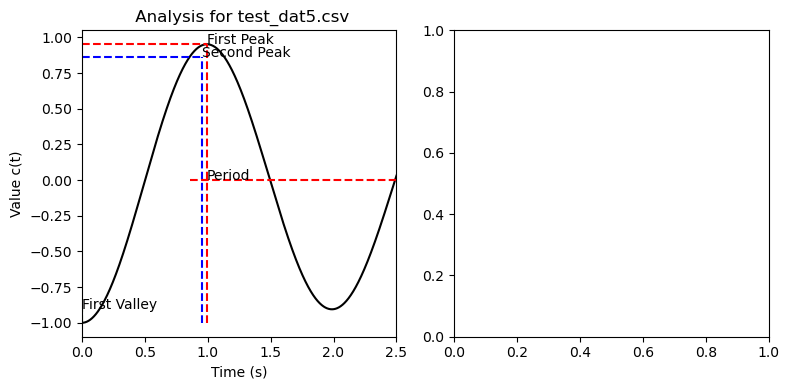

In [34]:
nrows = 1
ncols = 2
fig, axs = plt.subplots(nrows, ncols, figsize=(8, 4))


# Run and plot the simulation with the mass increased to 10.
# Other parameters are the same as in the part b.

test_rams3 = {"c_initial": -1.0, "system_mass": 10.0, "system_spring": 100.0, "system_damping": 1.0}
test_dat5 = solve_system(test_rams3, t)
with open('test_dat5.csv', 'w', newline = '') as csvfile:
    fieldnames = ['time', 'value']  
    writer = csv.DictWriter(csvfile, fieldnames = fieldnames)
    for value in test_dat5:
        writer.writerow({'time': value[0], 'value': value[1]}) 
    csvfile.close()
dict_bigger_mass_analysis = analyze_data("test_dat5.csv", m=10.0)
print(dict_bigger_mass_analysis)
plot_system(axs[0], "test_dat5.csv", m=10.0)

# Make it fit better
fig.tight_layout()

In [35]:
# Check your analysis (set dict_bigger_mass_analysis)
assert(compare_dictionaries('Data/sim_and_plot_answer_c.json', dict_bigger_mass_analysis))

Key c_final is not close, correct value 2.8029506801470045e-05, incorrect -0.34030034761477124
Key perc_overshoot is not close, correct value 95.15928441165063, incorrect 43.74539007970993
Key system_spring is not close, correct value 100.11740135673081, incorrect 106.90647545330384
Key system_damping is not close, correct value 0.9993558998096468, incorrect 16.643031890195225


AssertionError: 

In [109]:
grader.check("bigger_mass")

bigger_mass results:
    bigger_mass - 1 result:
        ❌ Test case failed
        Trying:
            assert(np.isclose(dict_bigger_mass_analysis["system_spring"], 100.11740135673081, atol=0.2))
        Expecting nothing
        **********************************************************************
        Line 1, in bigger_mass 0
        Failed example:
            assert(np.isclose(dict_bigger_mass_analysis["system_spring"], 100.11740135673081, atol=0.2))
        Exception raised:
            Traceback (most recent call last):
              File "c:\Users\yeasshhhh\anaconda3\Lib\doctest.py", line 1351, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest bigger_mass 0[0]>", line 1, in <module>
                assert(np.isclose(dict_bigger_mass_analysis["system_spring"], 100.11740135673081, atol=0.2))
            AssertionError

## Hours and collaborators
Required for every assignment - fill out before you hand-in.

Listing names and websites helps you to document who you worked with and what internet help you received in the case of any plagiarism issues. You should list names of anyone (in class or not) who has substantially helped you with an assignment - or anyone you have *helped*. You do not need to list TAs.

Listing hours helps us track if the assignments are too long.

In [ ]:

# List of names (creates a set)
worked_with_names = {"none"}
# List of URLS TCW3 (creates a set)
websites = {"<https://stackoverflow.com/questions/23546349/loading-text-file-containing-both-float-and-string-using-numpy-loadtxt>, <https://www.geeksforgeeks.org/python-value-error-math-domain-error-in-python/>,<https://stackoverflow.com/questions/27154793/matplotlib-vline-label-parameter-not-showing>, <https://stackoverflow.com/questions/15815854/how-to-add-column-to-numpy-array>, <https://www.youtube.com/watch?v=loHgpQvQxUI&t=113s&ab_channel=thehardwareguy>   "}
# Approximate number of hours, including lab/in-class time
hours = 28

In [ ]:
grader.check("hours_collaborators")

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

Submit just the .ipynb file to Gradescope, HWK2 Spring Mass damp.

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False, run_tests=True)